In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 9 (Query Translation - HyDE)"

# Query translation

![](images/query-translation-01.png)

# Part 9: Query Translation - HyDE

![](images/09-hyde.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-449c178e-2364-4fb7-bf9b-b92d52287eb4-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

## RAG

In [14]:
from typing import Annotated, TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
import numpy as np

In [15]:
hyde_prompt_template = """Please write a passage to answer the question
Question: {question}
Passage:"""
print(hyde_prompt_template)

Please write a passage to answer the question
Question: {question}
Passage:


In [16]:
rag_prompt_template = """Answer the following question based on this context:

{context}

Question: {question}
"""
print(rag_prompt_template)

Answer the following question based on this context:

{context}

Question: {question}



In [17]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [18]:
query = "What is task decomposition for LLM agents?"

In [19]:
class State(TypedDict):
    question: str
    generated_documents: list[str]
    hyde_embeddings: np.ndarray
    context: list[Document]
    answer: str

In [20]:
def generate_documents(state: State, config: RunnableConfig) -> list[Document]:
    generated_documents_count = config['configurable'].get("generated_documents_count", 3)
    
    hyde_prompt = hyde_prompt_template.format(
        question=state["question"]
    )
    generated_documents = llm.batch([hyde_prompt] * generated_documents_count)
    
    return {"generated_documents": [document.content for document in generated_documents]}


def calculate_hyde_embeddings(state: State):
    question_embeddings = np.array(embeddings.embed_query(state['question']))
    generated_documents_embeddings = np.array(embeddings.embed_documents(state['generated_documents']))
    hyde_embeddings = np.vstack([question_embeddings, generated_documents_embeddings]).mean(axis=0)
    return {"hyde_embeddings": hyde_embeddings}


def get_relevant_documents(state: State):
    documents = vectorstore.similarity_search_by_vector(state["hyde_embeddings"])
    return {"context": documents}


def generate_answer(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        context=docs_content,
        question=state["question"]
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}

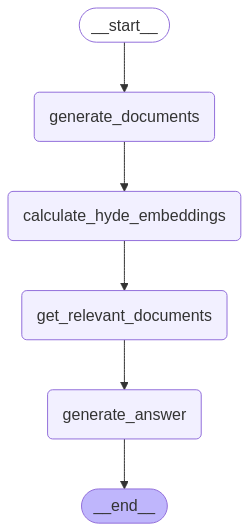

In [21]:
graph_builder = StateGraph(State)

graph_builder.add_node("generate_documents", generate_documents)
graph_builder.add_node("calculate_hyde_embeddings", calculate_hyde_embeddings)
graph_builder.add_node("get_relevant_documents", get_relevant_documents)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "generate_documents")
graph_builder.add_edge("generate_documents", "calculate_hyde_embeddings")
graph_builder.add_edge("calculate_hyde_embeddings", "get_relevant_documents")
graph_builder.add_edge("get_relevant_documents", "generate_answer")
graph_builder.add_edge("generate_answer", END)
graph = graph_builder.compile()
graph

In [22]:
print(query)

response = graph.invoke({"question": query})

display(Pretty(response, max_depth=2))
display(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'generated_documents': [
        'Task decomposition for Large Language Model (LLM) agents refers to the process of breaking down complex 
tasks or problems into smaller, more manageable sub-tasks that can be addressed sequentially or concurrently. This 
method leverages the capabilities of LLMs to analyze and understand diverse contexts, allowing them to tackle 
intricate challenges more effectively. \n\nBy decomposing a task, an LLM agent can focus on one aspect at a time, 
minimizing cognitive overload and improving the clarity of its outputs. For instance, if an agent is tasked with 
writing a research paper, it might decompose this task into several key sub-tasks: conducting literature reviews, 
developing an outline, drafting sections, and editing for coherence and style. \n\nEach of these sub-tasks can be 
handled individually, allowing the agent to produce high-quality responses for each component before integrating 
them into a coherent final product. This approach not only enhances the performance and efficiency of LLM agents 
but also makes it easier for users to interact with and guide the completion of complex tasks. In summary, task 
decomposition serves as a crucial strategy to optimize LLM functionality and output quality, enabling them to 
effectively manage extensive and multifaceted assignments.',
        "Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex 
tasks or objectives into smaller, manageable components that can be more easily executed by the language model. 
This approach enhances the model's efficiency and effectiveness in handling intricate queries or multi-step 
processes.\n\nIn practical terms, task decomposition involves identifying the various subtasks that contribute to 
an overall goal. For instance, if the objective is to write a research paper, the decomposition might include 
defining the research question, conducting a literature review, outlining sections, drafting content, and revising 
the final document. By segmenting the task, the LLM can focus on one aspect at a time, allowing for more precise 
and contextually relevant responses.\n\nThis method also allows for improved coordination when multiple LLM agents 
are involved, as each agent can specialize in specific subtasks. Consequently, task decomposition not only 
increases the accuracy of outputs but also streamlines the overall workflow, making it easier for users to achieve 
their desired results.",
        'Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down a complex 
task into smaller, more manageable components that can be individually understood and executed by the model. This 
approach involves identifying the various sub-tasks or steps required to achieve the overall objective, allowing 
the LLM to focus on specific aspects of a task one at a time. \n\nBy decomposing tasks, LLM agents can enhance 
their problem-solving capabilities, improve efficiency, and reduce the likelihood of errors. For example, if the 
overall task is to write a research paper, task decomposition might involve first gathering information, then 
creating an outline, followed by writing each section, and finally editing the document. Each of these sub-tasks 
can be addressed sequentially or independently, enabling a more structured approach to complex 
challenges.\n\nAdditionally, task decomposition can facilitate better collaboration between LLMs and human users, 
as both parties can work on discrete components of a project. It also allows the model to leverage its strengths in
specific domains (like generating text or analyzing data) while simplifying the cognitive load required to 
understand a multi-faceted task. Overall, task decomposition is a critical strategy for maximizing the potential of
LLM agents in various applications, from natural language processing to automated decision

Task decomposition for LLM (large language model) agents refers to the process of breaking down complex tasks into 
smaller, more manageable subgoals. This is accomplished using a technique known as Chain of Thought (CoT), where   
the model is prompted to “think step by step.” By doing so, the agent can transform a large, complicated task into 
simpler, sequential steps that are easier to handle. This not only aids in effectively managing complex tasks but  
also provides insight into the model’s reasoning and thought process.

In [23]:
print(query)

config = {
    "configurable": {
        "generated_documents_count": 5,   
    }
}
response = graph.invoke({"question": query}, config=config)

display(Pretty(response, max_depth=2))
display(Markdown(response["answer"]))

What is task decomposition for LLM agents?


{
    'question': 'What is task decomposition for LLM agents?',
    'generated_documents': [
        'Task decomposition for Large Language Model (LLM) agents refers to the process of breaking down complex 
tasks into smaller, more manageable sub-tasks that can be tackled individually. This approach enhances the 
efficiency and effectiveness of LLMs in various applications, including natural language understanding, data 
analysis, and problem-solving scenarios. By analyzing a larger task and identifying its constituent components, LLM
agents can focus on each part with greater precision, leading to improved outcomes.\n\nFor example, if an LLM is 
tasked with writing a research paper, task decomposition would involve dividing the process into specific actions 
such as conducting literature reviews, drafting sections, generating references, and editing the final document. By
systematically addressing these smaller tasks, the LLM can maintain clarity and coherence while also ensuring that 
each aspect is addressed thoroughly.\n\nMoreover, task decomposition allows for parallel processing, where 
different sub-tasks can be handled simultaneously or by multiple LLMs, thereby accelerating the overall workflow. 
It also aids in error reduction, as smaller components are often easier to validate and correct than a 
comprehensive task. Ultimately, task decomposition empowers LLM agents to operate more strategically and produce 
higher-quality outputs in diverse contexts.',
        'Task decomposition for LLM (Large Language Model) agents refers to the method of breaking down complex 
tasks into smaller, more manageable components that can be addressed individually. This approach is essential for 
optimizing the performance of LLMs, as it enables them to focus on specific elements of a problem without being 
overwhelmed by its entirety.\n\nWhen dealing with intricate queries or multi-step processes, task decomposition 
allows LLM agents to analyze each part systematically. For example, if the goal is to write a research paper, the 
tasks could be decomposed into components such as topic selection, literature review, outline creation, drafting, 
and revision. By addressing each component step-by-step, the LLM can generate more coherent and structured 
responses, ultimately leading to a higher quality output.\n\nFurthermore, task decomposition enhances the 
efficiency of LLM agents by facilitating parallel processing, where different sub-tasks can be tackled 
simultaneously or sequentially based on dependencies. This method not only improves the overall workflow but also 
aids in better resource allocation, allowing the model to utilize its capabilities more effectively. Overall, task 
decomposition plays a crucial role in maximizing the utility and performance of LLM agents in a variety of 
applications, from academic writing to complex problem-solving in diverse fields.',
        'Task decomposition for large language model (LLM) agents refers to the process of breaking down complex 
tasks into smaller, more manageable sub-tasks that can be addressed more easily by the model. This approach 
enhances the efficiency and effectiveness of LLMs in various applications, as it allows them to focus on specific 
components of a broader task one at a time. By decomposing a task, an LLM can leverage its abilities to generate 
coherent responses, extract relevant information, and perform reasoning in a more structured manner.\n\nFor 
instance, when given a multifaceted question, an LLM agent might first identify key components, such as gathering 
data, analyzing context, and synthesizing a final response. Each of these components can then be processed 
sequentially or in parallel, which increases the likelihood of achieving accurate and comprehensive results. 
Additionally, task decomposition can facilitate iterative improvements, as each sub-task can be reviewed and 
refined independently before being integrated into the overall solution. Ultimate

Task decomposition for LLM agents is the process of breaking down complicated tasks into smaller, manageable       
subgoals. This approach allows agents to efficiently handle complex tasks by transforming large, challenging       
objectives into simpler, more easily addressable steps. The technique of Chain of Thought (CoT) prompting enhances 
this process by instructing the model to "think step by step," which utilizes additional computational resources   
during test time to articulate the model's reasoning and planning. This structured decomposition not only aids in  
task execution but also provides insight into the model’s thought process.